# MLP Autoencoder


## IMPORT

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import random
import cv2
import seaborn as sns
import os
from tensorflow.keras.preprocessing import image  # Import this for image.array_to_img
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter  # Import Counter at the top
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


## LOAD DATA

In [5]:
# Function to load the CASIA WebFace dataset with resizing applied
def load_casia_webface_data(dataset_path, max_classes, target_size=(64, 64)):
    images = []
    labels = []
    label_map = {}
    current_label = 0

    # Iterate through the directory structure
    for subdir, dirs, _ in os.walk(dataset_path):
        for dir_name in sorted(dirs):
            if dir_name == 'casia-webface':
                print(f"Skipping folder: {dir_name}")
                continue

            if current_label >= max_classes:
                break

            # Define the path for each identity folder
            identity_dir = os.path.join(subdir, dir_name)
            label_map[current_label] = dir_name  # Map the label to the identity

            # print(f"Processing identity: {dir_name} (Label {current_label})")  # Debugging line

            # Iterate through images in each identity folder
            for img_file in os.listdir(identity_dir):
                img_path = os.path.join(identity_dir, img_file)

                # Only process valid image files
                if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                # Read the image without any preprocessing
                img = cv2.imread(img_path)

                # Check if the image was loaded properly
                if img is None:
                    print(f"Warning: Unable to read image {img_path}")
                    continue

                # Resize image to the target size (64x64)
                img = cv2.resize(img, target_size)

                # Append image and its label
                images.append(img)
                labels.append(current_label)

            current_label += 1

        # Stop if we have reached the maximum number of classes
        if current_label >= max_classes:
            break

    # Check if any images were loaded
    if not images:
        raise ValueError("No images were loaded. Please check the dataset structure and image paths.")

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    print(f"Loaded {images.shape[0]} images.")  # Debugging line
    
    return images, labels, label_map

# Path to the extracted dataset (make sure this path is correct)
dataset_path = r"MileStone2_CI/archive"

# Maximum number of classes to use
max_classes = 51

# Load dataset with resizing
try:
    images, labels, label_map = load_casia_webface_data(dataset_path, max_classes=max_classes, target_size=(64, 64))
    print(f"Loaded {images.shape[0]} images with {len(label_map)} identities.")
    
except ValueError as e:
    print(f"Error: {e}")


Skipping folder: casia-webface
Loaded 9437 images.
Loaded 9437 images with 51 identities.


## Normalize the features by subtracting the mean and dividing by the standard deviation for each channel


In [7]:
mean = np.mean(images, axis=(0, 1, 2), keepdims=True)
std = np.std(images, axis=(0, 1, 2), keepdims=True)

normalized_features = (images - mean) / std

In [8]:
# Select a random image from the normalized dataset
image_index = random.choice(range(len(normalized_features)))
selected_image = normalized_features[image_index]

# Print the pixel matrix for the selected image
print(f"Pixel Matrix for Image Index {image_index} (after normalization):")
print(selected_image)


Pixel Matrix for Image Index 7498 (after normalization):
[[[ 2.76907008  2.46031243  1.6813123 ]
  [ 2.75219986  2.42743456  1.6813123 ]
  [ 2.75219986  2.42743456  1.6813123 ]
  ...
  [ 2.53288704  2.2137284   1.4970722 ]
  [ 2.53288704  2.2137284   1.4970722 ]
  [ 2.56662747  2.19728947  1.52541683]]

 [[ 2.76907008  2.46031243  1.6813123 ]
  [ 2.76907008  2.46031243  1.6813123 ]
  [ 2.75219986  2.42743456  1.6813123 ]
  ...
  [ 2.54975725  2.23016734  1.53958915]
  [ 2.53288704  2.2137284   1.52541683]
  [ 2.56662747  2.19728947  1.52541683]]

 [[ 2.76907008  2.46031243  1.6813123 ]
  [ 2.76907008  2.46031243  1.6813123 ]
  [ 2.76907008  2.46031243  1.6813123 ]
  ...
  [ 2.54975725  2.23016734  1.53958915]
  [ 2.53288704  2.2137284   1.52541683]
  [ 2.56662747  2.19728947  1.52541683]]

 ...

 [[ 2.34731465  1.85207182  1.53958915]
  [ 2.19548269  1.75343821  1.59627841]
  [ 1.72311661  1.35890376  1.53958915]
  ...
  [ 2.41479552  2.06577798  1.36952137]
  [ 2.43166573  2.08221692 

## Visualize the first image before and after normalization


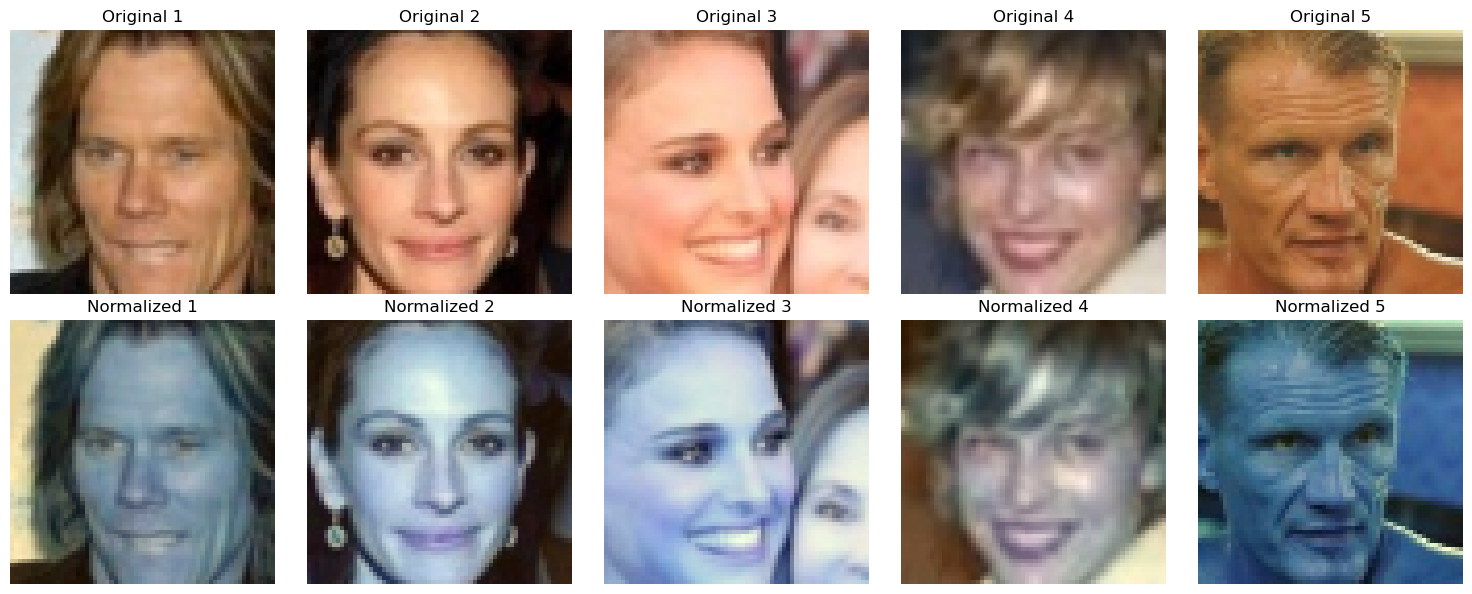

In [10]:


# Function to visualize a few original and normalized images
def visualize_original_and_normalized(original_images, normalized_images, labels, label_map, num_samples=5):
    # Select random indices
    random_indices = np.random.choice(len(original_images), num_samples)

    # Create a plot with two rows: original and normalized
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i, idx in enumerate(random_indices):
        # Original image
        original_image = original_images[idx]

        # Normalized image
        normalized_image = normalized_images[idx]

        # Display the original image in the first row
        axes[0, i].imshow(cv2.cvtColor(original_image.astype(np.uint8), cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')

        # Display the normalized image in the second row
        # Rescale normalized image for visualization (optional step for better visualization)
        normalized_image_rescaled = (normalized_image - np.min(normalized_image)) / (np.max(normalized_image) - np.min(normalized_image))  # Rescale to [0, 1]
        axes[1, i].imshow(normalized_image_rescaled)
        axes[1, i].set_title(f"Normalized {i+1}")
        axes[1, i].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Visualize original and normalized images
visualize_original_and_normalized(images, normalized_features, labels, label_map, num_samples=5)


## SPLIT DATA

In [12]:

# Split the data into train and test sets (70% training, 30% testing + validation)
X_train, X_test, y_train, y_test = train_test_split(normalized_features, labels, test_size=0.2, random_state=123, stratify=labels)


In [13]:
# Check the shapes of the splits
print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Test set size: {X_test.shape}, {y_test.shape}")

Training set size: (7549, 64, 64, 3), (7549,)
Test set size: (1888, 64, 64, 3), (1888,)


In [16]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [23]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)

# Balance Dataset using SMOTE
X_train_flat = X_train.reshape(len(X_train), -1)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train)
X_train_balanced = X_train_balanced.reshape(-1, 64, 64, 3)
print(f"Balanced training set size: {X_train_balanced.shape[0]} images")

Balanced training set size: 23664 images


In [ ]:
X_train_balanced.shape


## ENCODER DECODER(before CV)

In [29]:
encoding_dim = 128  # Latent space dimension (increase size for better performance)

# Build the autoencoder model
input_img = tf.keras.Input(shape=(64, 64, 3))

# Flatten the input image to 1D vector
x = tf.keras.layers.Flatten()(input_img)

# Encoder: Multiple Dense layers to progressively compress the image into a latent representation
x = tf.keras.layers.Dense(1024, activation='relu')(x)  # First hidden layer
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Second hidden layer

encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(x)  # Latent space layer

# Decoder: Multiple Dense layers to progressively reconstruct the image from the latent representation
x = tf.keras.layers.Dense(512, activation='relu')(encoded)  # First hidden layer of the decoder
x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Second hidden layer of the decoder
decoded = tf.keras.layers.Dense(64 * 64 * 3, activation='sigmoid')(x)  # Output layer with 'sigmoid'

# Reshape the decoded output back into the original image shape
decoded = tf.keras.layers.Reshape((64, 64, 3))(decoded)

# Define the model that takes an image and outputs the reconstructed image
autoencoder = tf.keras.Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

# Display the summary of the model to verify the architecture
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12288)          │    12,595,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,360,960 (100.56 MB)

 Trainable params: 26,360,960 (100.56 MB)

 Non-trainable params: 0 (0.00 B)

## APLLY CROSS VALIDATION

In [41]:
# Function to build the autoencoder model with parameterized layers and neurons
def build_autoencoder(neurons_per_layer, encoding_dim=128):
    input_img = tf.keras.Input(shape=(64, 64, 3))
    x = tf.keras.layers.Flatten()(input_img)

    # Encoder: Add layers based on the neuron configuration
    for neurons in neurons_per_layer:
        x = tf.keras.layers.Dense(neurons, activation='relu')(x)

    # Latent space
    encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(x)

    # Decoder: Reverse the layer configuration
    x = encoded
    for neurons in reversed(neurons_per_layer):
        x = tf.keras.layers.Dense(neurons, activation='relu')(x)

    # Output layer: Reconstruct the image
    decoded = tf.keras.layers.Dense(64 * 64 * 3, activation='sigmoid')(x)
    decoded = tf.keras.layers.Reshape((64, 64, 3))(decoded)

    # Compile the model
    autoencoder = tf.keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return autoencoder

# Example dataset (replace this with your actual data)
X = np.random.rand(10255, 64, 64, 3)  # Example: 10255 images of 64x64 with 3 channels

# Hyperparameter search space
layer_neuron_combinations = [
    [128],          # Single layer with 128 neurons
    [128, 256],     # Two layers: first with 128 neurons, second with 256
    [256, 512],     # Two layers: first with 256 neurons, second with 128
    [128, 256, 512] # Three layers: 128 -> 256 -> 512
]

# Cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

# Sampling size
sample_fraction = 0.1  # Use 10% of the training set in each fold

for neuron_config in layer_neuron_combinations:
    print(f"Testing configuration: {neuron_config} neurons per layer")
    fold_losses = []

    # Perform K-Fold Cross-Validation
    for train_idx, val_idx in kfold.split(X):
        # Split the dataset into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]

        # Take a random sample of the training data
        train_sample_size = int(len(X_train) * sample_fraction)
        sampled_indices = np.random.choice(len(X_train), train_sample_size, replace=False)
        X_train_sampled = X_train[sampled_indices]

        # Build the autoencoder model
        autoencoder = build_autoencoder(neurons_per_layer=neuron_config)

        # Train the model
        history = autoencoder.fit(
            X_train_sampled, X_train_sampled,  # Input is the target (autoencoder)
            validation_data=(X_val, X_val),
            epochs=10,  # Adjust as needed
            batch_size=32,
            verbose=0
        )

        # Record validation loss for the fold
        val_loss = history.history['val_loss'][-1]
        fold_losses.append(val_loss)

    # Compute the average validation loss for the configuration
    avg_val_loss = np.mean(fold_losses)
    results[tuple(neuron_config)] = avg_val_loss
    print(f"Average Validation Loss for {neuron_config}: {avg_val_loss}")

# Find the best configuration
best_config = min(results, key=results.get)
print(f"Best Configuration: {best_config} with Loss: {results[best_config]}")


Testing configuration: [128] neurons per layer
Average Validation Loss for [128]: 0.08340911567211151
Testing configuration: [128, 256] neurons per layer
Average Validation Loss for [128, 256]: 0.08338384628295899
Testing configuration: [256, 512] neurons per layer
Average Validation Loss for [256, 512]: 0.08340034037828445
Testing configuration: [128, 256, 512] neurons per layer
Average Validation Loss for [128, 256, 512]: 0.08340479880571365
Best Configuration: (128, 256) with Loss: 0.08338384628295899


## re aplly splitting

In [39]:

# Split the data into train and test sets (70% training, 30% testing + validation)
X_train, X_temp, y_train, y_temp = train_test_split(normalized_features, labels, test_size=0.3, random_state=123, stratify=labels)

# Split the temp data into validation and test sets (50% validation, 50% test of the 30% left)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(X_train)

# Balance Dataset using SMOTE
X_train_flat = X_train.reshape(len(X_train), -1)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train)
X_train_balanced = X_train_balanced.reshape(-1, 64, 64, 3)
print(f"Balanced training set size: {X_train_balanced.shape[0]} images")

## ENCODER DECODER(after CV)

In [24]:
encoding_dim = 64  # Latent space dimension (increase size for better performance)

# Build the autoencoder model
input_img = tf.keras.Input(shape=(64, 64, 3))

# Flatten the input image to 1D vector
x = tf.keras.layers.Flatten()(input_img)

# Encoder: Multiple Dense layers to progressively compress the image into a latent representation
x = tf.keras.layers.Dense(256, activation='linear')(x)  # First hidden layer
x = tf.keras.layers.Dense(128, activation='linear')(x)  # Second hidden layer

encoded = tf.keras.layers.Dense(encoding_dim, activation='linear')(x)  # Latent space layer

# Decoder: Multiple Dense layers to progressively reconstruct the image from the latent representation
x = tf.keras.layers.Dense(128, activation='linear')(encoded)  # First hidden layer of the decoder
x = tf.keras.layers.Dense(256, activation='linear')(x)  # Second hidden layer of the decoder
decoded = tf.keras.layers.Dense(64 * 64 * 3, activation='linear')(x)  # Output layer with 'sigmoid'

# Reshape the decoded output back into the original image shape
decoded = tf.keras.layers.Reshape((64, 64, 3))(decoded)

# Define the model that takes an image and outputs the reconstructed image
autoencoder = tf.keras.Model(input_img, decoded)

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

# Display the summary of the model to verify the architecture
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,145,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12288)          │     3,158,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,386,496 (24.36 MB)

 Trainable params: 6,386,496 (24.36 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:

# Reshape the data to match input shape for training
X_train_reshaped = X_train_balanced.reshape(-1, 64, 64, 3)
X_test_reshaped = X_test.reshape(-1, 64, 64, 3)

# Train the autoencoder with reshaped images
history = autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)

# After training, extract the encoder part of the autoencoder to get the encoded features
encoder = tf.keras.Model(input_img, encoded)
#encoder.save("encoder.h5")


Epoch 1/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5728 - loss: 0.3910 - val_accuracy: 0.7600 - val_loss: 0.0901
Epoch 2/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7709 - loss: 0.0992 - val_accuracy: 0.7843 - val_loss: 0.0765
Epoch 3/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7890 - loss: 0.0879 - val_accuracy: 0.8001 - val_loss: 0.0751
Epoch 4/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7977 - loss: 0.0853 - val_accuracy: 0.7824 - val_loss: 0.0740
Epoch 5/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7971 - loss: 0.0868 - val_accuracy: 0.8025 - val_loss: 0.0747
Epoch 6/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7933 - loss: 0.0917 - val_accuracy: 0.8031 - val_loss: 0.0710
Epoch 7/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7978 - loss: 0.0851 - val_accuracy: 0.7926 - val_loss: 0.0735
Epoch 8/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.7973 - loss: 0.0866 - 

In [28]:
#encoder = load_model("encoder.h5")
# Extract the encoded features for the training, validation, and test sets
encoded_features_train = encoder.predict(X_train_reshaped)
encoded_features_test = encoder.predict(X_test_reshaped)

encoded_features_train = encoded_features_train.reshape(encoded_features_train.shape[0], -1)
encoded_features_test = encoded_features_test.reshape(encoded_features_test.shape[0], -1)

740/740 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [29]:
encoded_test_loss,encoded_test_accuracy=autoencoder.evaluate(X_test_reshaped,X_test_reshaped)
print(f" Encoder Loses: {encoded_test_loss :.2f}") 
print(f" Encoder Accuracy: {encoded_test_accuracy * 100:.2f}%") 


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7846 - loss: 0.1135
 Encoder Loses: 0.11
 Encoder Accuracy: 78.44%


295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


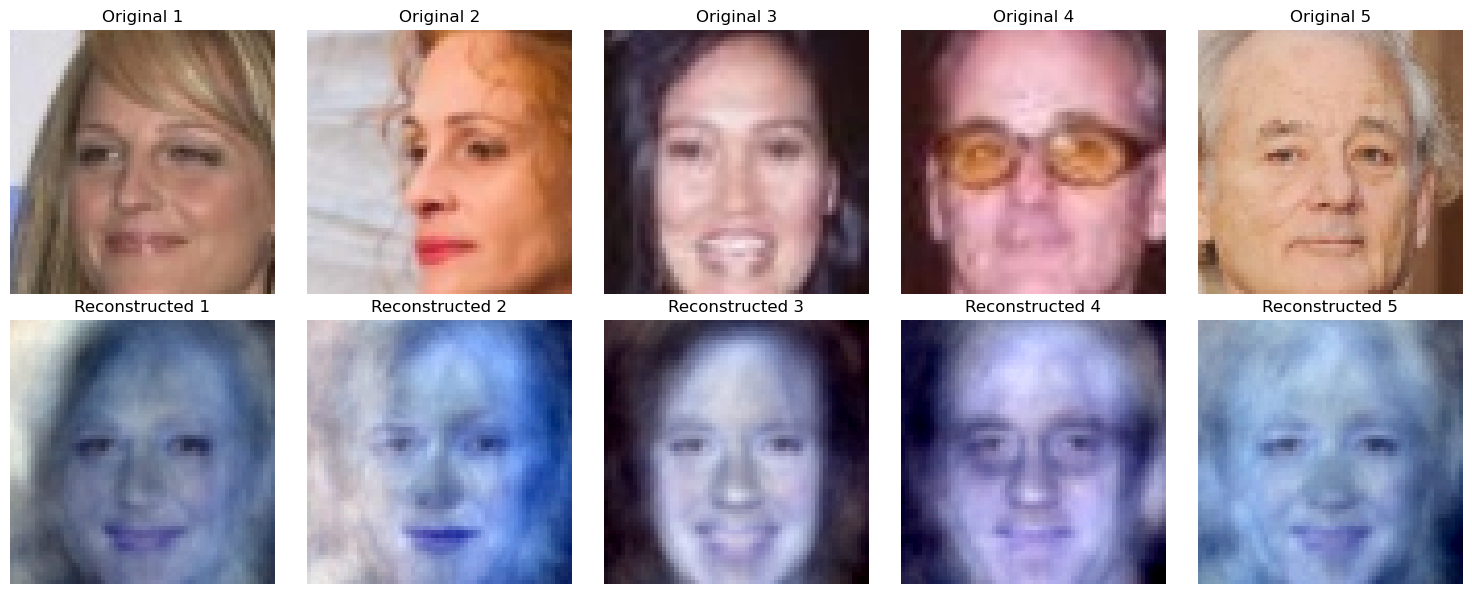

In [55]:
def visualize_original_and_reconstructed(original_images, reconstructed_images, num_samples=5):
    # Select random indices
    random_indices = np.random.randint(0, len(original_images), num_samples)

    # Create a plot
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    for i, idx in enumerate(random_indices):
        # Original image
        original_image = original_images[idx]

        # Reconstructed image
        reconstructed_image = reconstructed_images[idx]

        # Display the original image in the first row
        axes[0, i].imshow(cv2.cvtColor(original_image.astype(np.uint8), cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')

        # Ensure the reconstructed image is within the valid range and normalize
        reconstructed_image = np.clip(reconstructed_image, 0, 255)  # Ensure values are within [0, 255]
        reconstructed_image = reconstructed_image / 255.0  # Normalize to [0, 1] for display

        # Display the reconstructed image in the second row
        axes[1, i].imshow(reconstructed_image)
        axes[1, i].set_title(f"Reconstructed {i+1}")
        axes[1, i].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Generate reconstructed images using the autoencoder
# Assuming 'autoencoder' is your trained model and you have reshaped images for input
reconstructed_images = autoencoder.predict(images)

# Visualize original and reconstructed images
visualize_original_and_reconstructed(images, reconstructed_images, num_samples=5)


## VIsualization

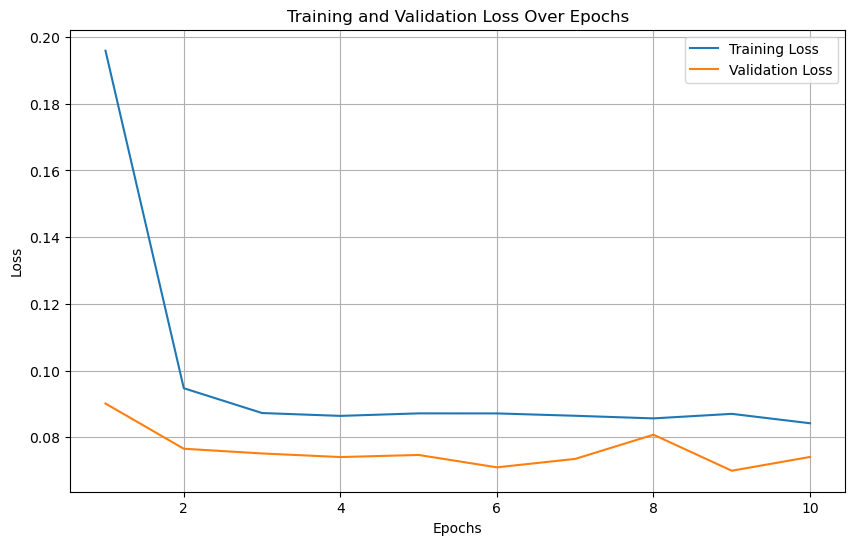

In [58]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Classifier

In [33]:
# Train the SVM classifier on the encoded features of the training set
svm = SVC(kernel='rbf',C=100,random_state=42,gamma='scale',degree=3)  # You can experiment with different kernels like 'rbf', 'poly', etc.
svm.fit(encoded_features_train, y_train_balanced)

# Make predictions on the test set
y_pred = svm.predict(encoded_features_test)

# Evaluate the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Recognition Accuracy: {accuracy * 100:.2f}%")


Recognition Accuracy: 53.18%


## Display a random image from the test set along with its true and predicted labels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


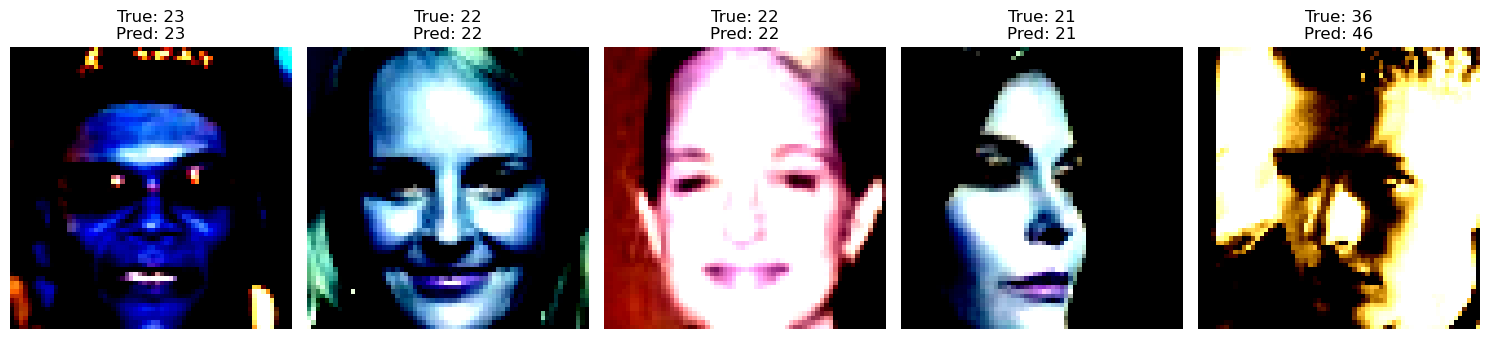

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = np.random.randint(0, len(X_test), num_samples)

# Create a figure for displaying images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

# Ensure axes is iterable even if there's only one axis
if num_samples == 1:
    axes = [axes]

for i, idx in enumerate(random_indices):
    # Get the test image and its true label
    test_image = X_test[idx]
    true_label = y_test[idx]
    
    # Ensure the image is displayed without any preprocessing
    # If it's normalized (values between 0 and 1), scale it back to [0, 255]
    if test_image.max() <= 1:
        test_image = (test_image * 255).astype(np.uint8)

    # Clip the image values to the valid range [0, 255] for display
    test_image = np.clip(test_image, 0, 255)

    # Get the predicted label using the classifier (SVM in this case)
    predicted_label = svm.predict([encoded_features_test[idx]])[0]

    # Display the image
    if len(test_image.shape) == 2:  # Grayscale image
        axes[i].imshow(test_image, cmap='gray')
    else:  # RGB image
        axes[i].imshow(test_image)

    # Display the true and predicted labels as titles
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')  # Hide axes for better visualization

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## confusion matrix

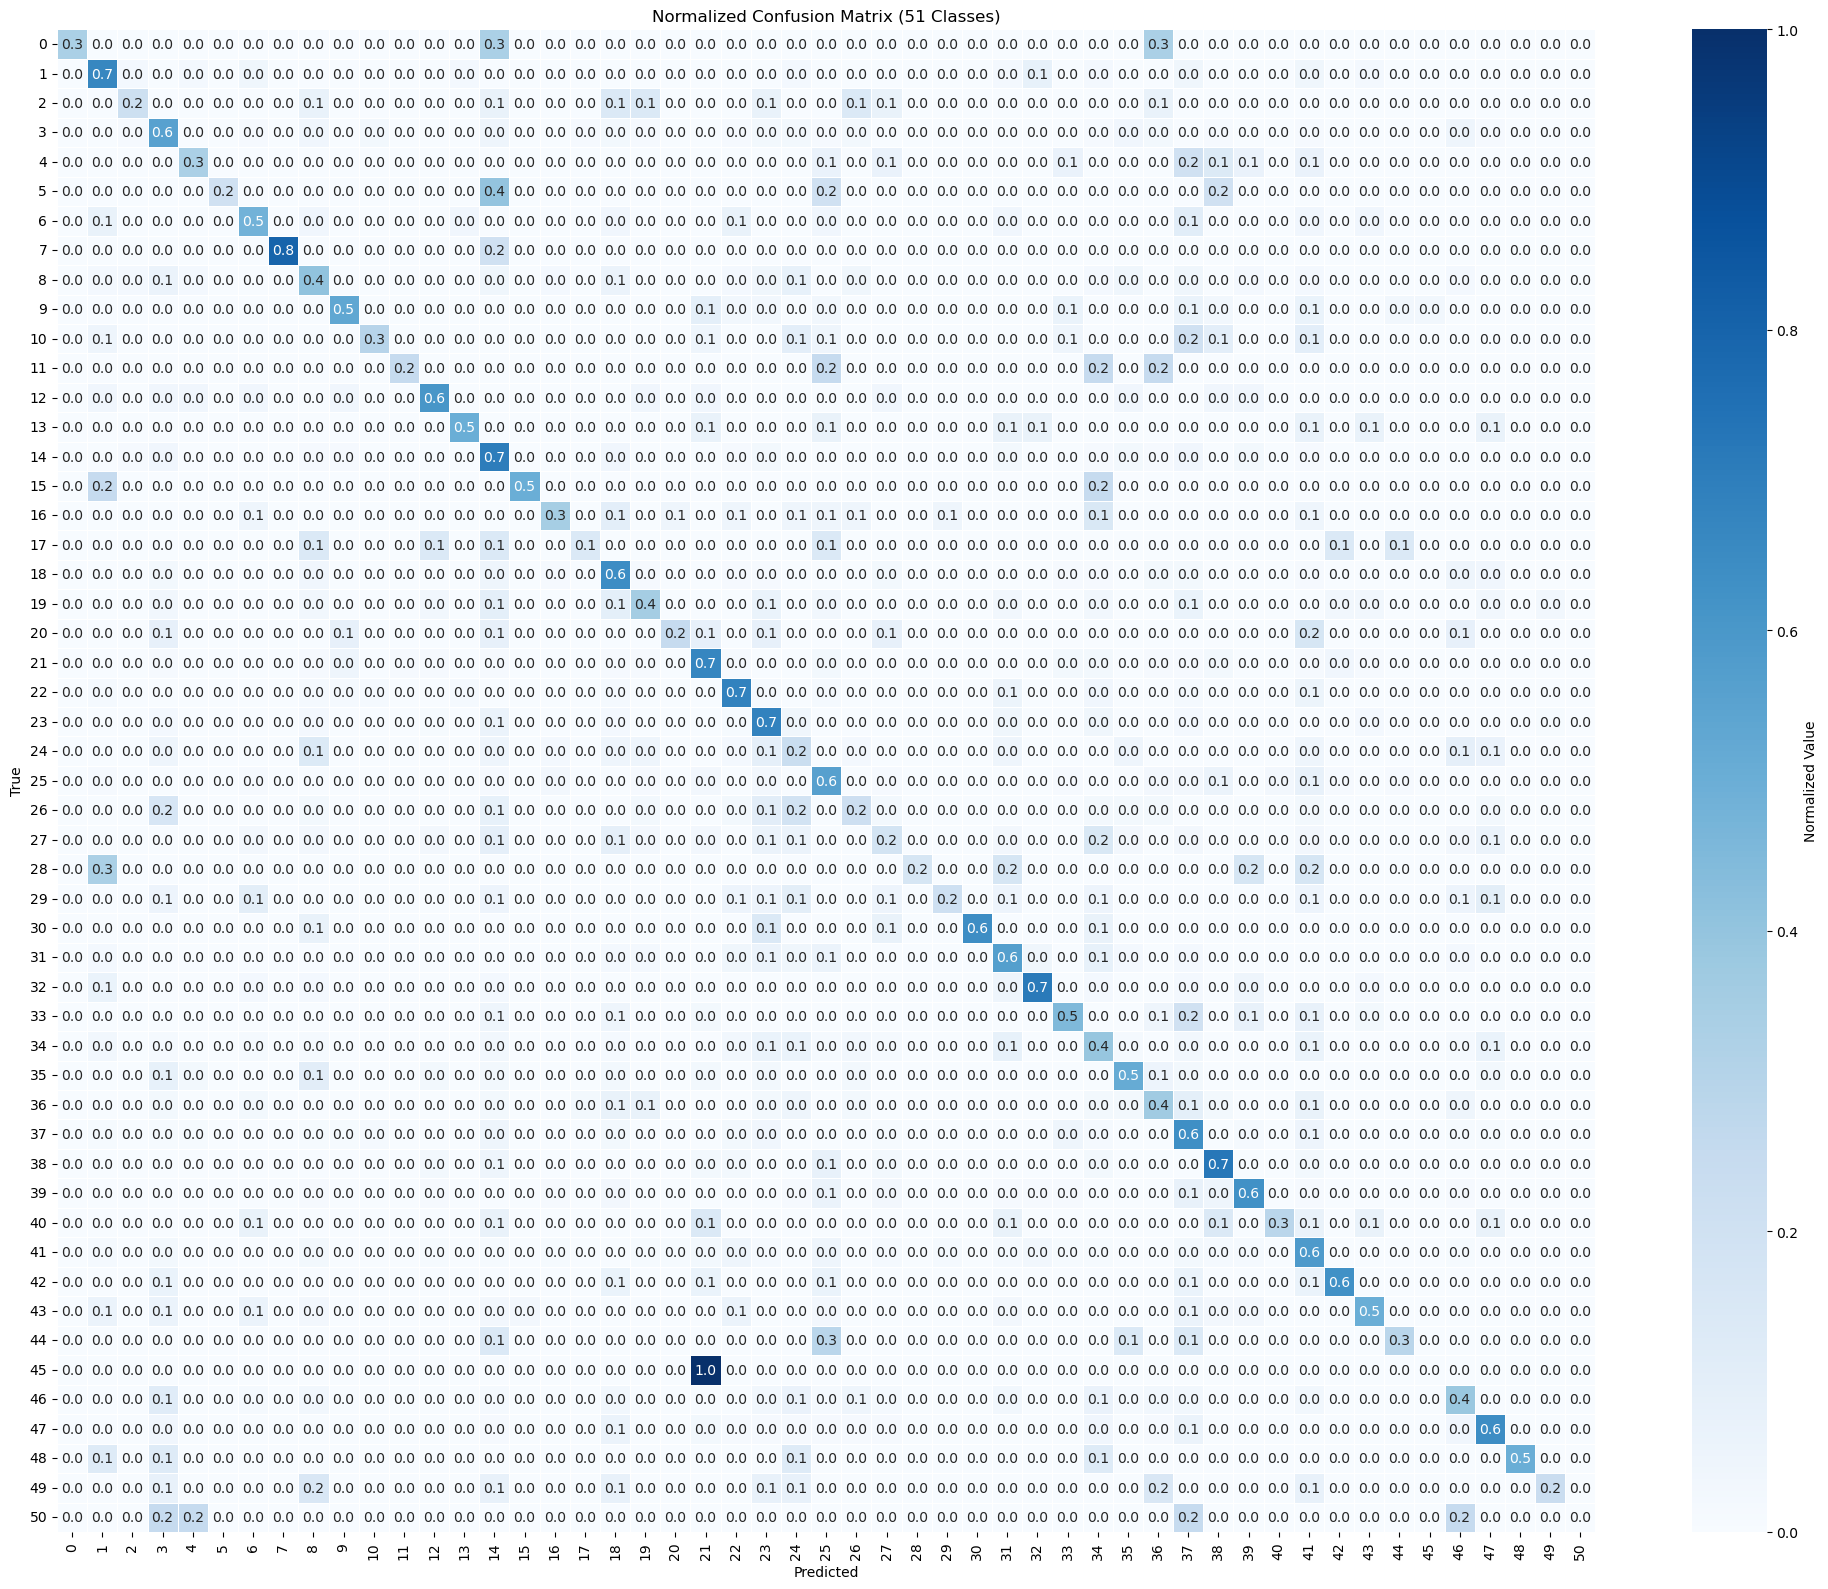

In [74]:
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(20, 16))  # Increase figure size for better visibility
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), 
            cbar_kws={'label': 'Normalized Value'}, linewidths=0.5)

# Rotate the labels to prevent overlapping
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (51 Classes)')

# Adjust layout for better readability
plt.tight_layout()
plt.show()
